In [5]:
import random
import time
import gc

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

from torchvision import transforms, datasets

import pandas as pd
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

from qkal.qkal import QKAL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)

random.seed(42)
torch.manual_seed(42)
degrees = range(3, 12)
EPOCHS = 10
LR = 1e-3


#---------------------------------------------------------------



def evaluate(model: nn.Module, loader: DataLoader, criterion: nn.Module):
    """Return accuracy, macro‑F1, and average loss on `loader`."""
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    running_loss = 0.0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item() * target.size(0)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.numel()
            y_true.extend(target.tolist())
            y_pred.extend(pred.tolist())
    acc = correct / total
    f1 = f1_score(y_true, y_pred, average="macro")
    avg_loss = running_loss / total
    return acc, f1, avg_loss


def train(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    logs: list[dict],          # list that will receive per‑epoch metric dicts
    run_info: dict,            # e.g. {"model": "KAL_NET", "degree": 4}
    *,
    epochs: int = 2,
    lr: float = 1e-3,
):
    """Train `model` for `epochs` epochs, logging a rich set of metrics."""

    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss()

    history = {
        "train_acc": [],
        "test_acc":  [],
        "train_loss": [],
        "test_loss":  [],
        "train_f1":   [],
        "test_f1":    [],
        "epoch_time": [],
    }

    for epoch in range(epochs):
        start_t = time.time()
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            opt.zero_grad(set_to_none=True)
            ce(model(data), target).backward()
            opt.step()

        tr_acc, tr_f1, tr_loss = evaluate(model, train_loader, ce)
        te_acc, te_f1, te_loss = evaluate(model, test_loader, ce)
        duration = time.time() - start_t

        history["train_acc"].append(tr_acc)
        history["test_acc"].append(te_acc)
        history["train_loss"].append(tr_loss)
        history["test_loss"].append(te_loss)
        history["train_f1"].append(tr_f1)
        history["test_f1"].append(te_f1)
        history["epoch_time"].append(duration)

        logs.append(
            {
                **run_info,
                "epoch": epoch + 1,
                "train_acc": tr_acc,
                "test_acc": te_acc,
                "train_loss": tr_loss,
                "test_loss": te_loss,
                "train_f1": tr_f1,
                "test_f1": te_f1,
                "epoch_time": duration,
            }
        )

        print(
            f"Epoch {epoch + 1}/{epochs}: "
            f"train_acc={tr_acc:.4f} test_acc={te_acc:.4f} "
            f"train_loss={tr_loss:.4f} test_loss={te_loss:.4f} "
            f"train_f1={tr_f1:.4f} test_f1={te_f1:.4f} "
            f"time={duration:.1f}s"
        )

    return history


transform = transforms.ToTensor()
train_full = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
subset_size = 12_000
subset_idx = torch.randperm(len(train_full))[:subset_size]
train_ds = Subset(train_full, subset_idx)

test_ds = datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

batch_size = 128
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)

test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

model_specs = [
    ("MODEL", QKAL),
    #you can add and test other models here.

]



metrics_logs: list[dict] = []
results_summary = []

for deg in degrees:
    for name, Net in model_specs:
        print(f"\n=== {name} (degree {deg}) ===")
        model = Net(deg)
        history = train(
            model,
            train_loader,
            test_loader,
            logs=metrics_logs,
            run_info={"model": name, "degree": deg},
            epochs=EPOCHS,
            lr=LR,
        )

        best_idx = max(range(EPOCHS), key=lambda i: history["test_acc"][i])
        results_summary.append(
            {
                "model": name,
                "degree": deg,
                "best_epoch": best_idx + 1,
                "best_test_acc": history["test_acc"][best_idx],
                "best_test_f1": history["test_f1"][best_idx],
            }
        )

        del model
        torch.cuda.empty_cache()
        gc.collect()



metrics_df = pd.DataFrame(metrics_logs)
summary_df = pd.DataFrame(results_summary)

metrics_df.to_csv("metrics_full.csv", index=False)
summary_df.to_csv("results_summary.csv", index=False)

print("\n--- Summary (best per run) ---")
print(summary_df)


pivot_acc = summary_df.pivot(index="degree", columns="model", values="best_test_acc")

pivot_acc.plot(marker="o")
plt.title("Best test accuracy vs Legendre degree")
plt.ylabel("Accuracy")
plt.xlabel("Degree")
plt.ylim(0.7, 1.0)
plt.grid(True)
plt.show()


Running on cpu


RuntimeError: Error downloading train-images-idx3-ubyte.gz:
Tried https://ossci-datasets.s3.amazonaws.com/mnist/, got:
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
Tried http://yann.lecun.com/exdb/mnist/, got:
HTTP Error 404: Not Found


In [ ]:
df = pd.read_csv("results_summary.csv")

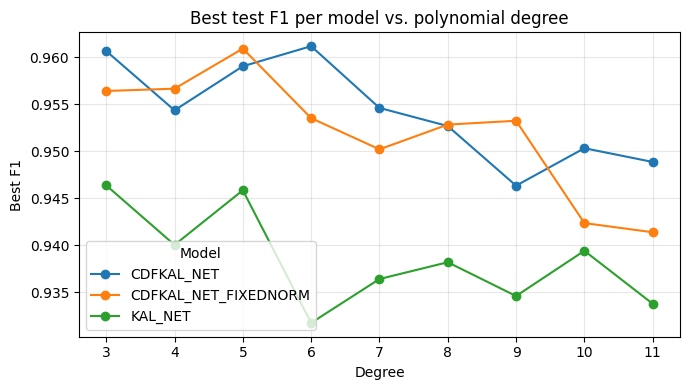

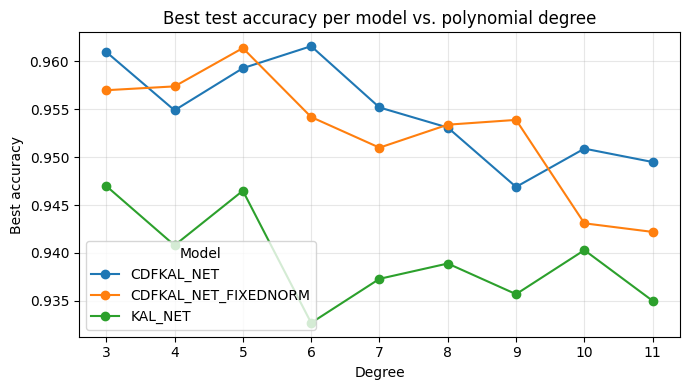

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

best_md = (
    df.groupby(['model', 'degree'])
      .agg(best_f1  = ('test_f1',  'max'),
           best_acc = ('test_acc', 'max'))
      .reset_index()
      .sort_values(['model', 'degree'])
)

plt.figure(figsize=(7,4))
for mdl, grp in best_md.groupby('model'):
    plt.plot(grp['degree'],
             grp['best_f1'],
             marker='o',
             label=mdl)

plt.title('Best test F1 per model vs. polynomial degree')
plt.xlabel('Degree')
plt.ylabel('Best F1')
plt.grid(True, alpha=.3)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


plt.figure(figsize=(7,4))
for mdl, grp in best_md.groupby('model'):
    plt.plot(grp['degree'],
             grp['best_acc'],
             marker='o',
             label=mdl)

plt.title('Best test accuracy per model vs. polynomial degree')
plt.xlabel('Degree')
plt.ylabel('Best accuracy')
plt.grid(True, alpha=.3)
plt.legend(title='Model')
plt.tight_layout()
plt.show()
